In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import iris

import metpy.calc as mpcalc
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
from custom_cmap import *

import matplotlib
%matplotlib inline

In [2]:
# plot characteristics 
lon_start = 88.0 # 88.0
lon_end = 130.0 # 130.0
lat_start = 5.5
lat_end = 7.0

height_level = 7000

Tp = 12
time = int(Tp)-12

In [3]:
# read in N768 MetUM data 
# gl_pe='/nobackup/earshar/borneo/case_20181021T1200Z_N768/nc/umglaa_pe{0:03d}.nc'.format(time)
# gl_pc='/nobackup/earshar/borneo/case_20181021T1200Z_N768/nc/umglaa_pc{0:03d}.nc'.format(time)
# gl_pb='/nobackup/earshar/borneo/case_20181021T1200Z_N768/nc/umglaa_pb{0:03d}.nc'.format(time)

gl_pe='/nobackup/earshar/borneo/case_20181021T1200Z_N768_v2/umglaa_pe{0:03d}.nc'.format(time)
gl_pb='/nobackup/earshar/borneo/case_20181021T1200Z_N768_v2/umglaa_pb{0:03d}.nc'.format(time)
    
input_data_pe = xr.open_dataset(gl_pe).metpy.assign_crs(grid_mapping_name='latitude_longitude',earth_radius=6371229.0) # vertical velocity 
input_data_pb = xr.open_dataset(gl_pb).metpy.assign_crs(grid_mapping_name='latitude_longitude',earth_radius=6371229.0) # theta + specific humidity

In [4]:
# create variable for v_tot (v-wind)
if Tp <= 12: 
    vwind = input_data_pe.v[1,:,:,:].sel(latitude_1=slice(lat_start, 
                                            lat_end)).sel(longitude_1=slice(lon_start, lon_end))
    uwind = input_data_pe.u[1,:,:,:].sel(latitude=slice(lat_start, 
                                            lat_end)).sel(longitude=slice(lon_start, lon_end))
    theta = input_data_pb.theta_1[1,:,:,:].sel(latitude=slice(lat_start,
                                            lat_end)).sel(longitude=slice(lon_start, lon_end))
    q = input_data_pb.q[1,:,:,:].sel(latitude=slice(lat_start,
                                            lat_end)).sel(longitude=slice(lon_start, lon_end))
else:
    vwind = input_data_pe.v.squeeze('t').sel(latitude_1=slice(lat_start, 
                                            lat_end)).sel(longitude=slice(lon_start, lon_end))
    uwind = input_data_pe.u.squeeze('t').sel(latitude=slice(lat_start, 
                                            lat_end)).sel(longitude_1=slice(lon_start, lon_end))
    theta = input_data_pb.theta_1.squeeze('t').sel(latitude=slice(lat_start,
                                            lat_end)).sel(longitude=slice(lon_start, lon_end))  
    # q = input_data_pb.q[1,:,:,:].sel(latitude=slice(lat_start,
    #                                         lat_end)).sel(longitude=slice(lon_start, lon_end))

### Interpolate to evenly spaced levels before calling metpy function

In [5]:
new_ht_levels = theta['hybrid_ht'].data.astype('int32')

theta = theta.interp(hybrid_ht=new_ht_levels,
                    method="linear").assign_coords(height_levels=("hybrid_ht",
                    new_ht_levels)).swap_dims({"hybrid_ht":
                                                "height_levels"
                                                }
                                                )

q = q.interp(hybrid_ht=new_ht_levels,
                    method="linear").assign_coords(height_levels=("hybrid_ht",
                    new_ht_levels)).swap_dims({"hybrid_ht":
                                                "height_levels"
                                                }
                                                )

### Calculate moist stability 

In [6]:
# calculate static stability
d_theta_dz = mpcalc.first_derivative(theta, axis=0)
d_theta_dz = d_theta_dz * (9.81 / theta)

# new moist stability calculation (January 2023)
moist_stability = q / d_theta_dz
# moist_stability = q * d_theta_dz * 1000000000.

In [7]:
q

<xarray.DataArray 'q' (height_levels: 70, latitude: 10, longitude: 180)>
array([[[1.72291733e-02, 1.71992611e-02, 1.72213465e-02, ...,
         1.79373920e-02, 1.78780593e-02, 1.80219617e-02],
        [1.71989668e-02, 1.72381382e-02, 1.71701852e-02, ...,
         1.77971479e-02, 1.78806856e-02, 1.80186480e-02],
        [1.72587913e-02, 1.72763281e-02, 1.72447991e-02, ...,
         1.77214798e-02, 1.78416297e-02, 1.80142410e-02],
        ...,
        [1.73952337e-02, 1.74461734e-02, 1.75043102e-02, ...,
         1.77314728e-02, 1.78505182e-02, 1.78658552e-02],
        [1.73196383e-02, 1.73613392e-02, 1.74369067e-02, ...,
         1.77155249e-02, 1.77830253e-02, 1.78608838e-02],
        [1.74255557e-02, 1.73020065e-02, 1.74386669e-02, ...,
         1.77577510e-02, 1.78061761e-02, 1.78577341e-02]],

       [[1.70990624e-02, 1.70647802e-02, 1.70910973e-02, ...,
         1.77678499e-02, 1.77008356e-02, 1.78538541e-02],
        [1.70650114e-02, 1.71076788e-02, 1.70395967e-02, ...,
         1.76330544e-02, 1.77212866e-02, 1.78551520e-02],
        [1.71277584e-02, 1.71472386e-02, 1.71129770e-02, ...,
         1.75699246e-02, 1.76924033e-02, 1.78624314e-02],
        ...,
        [1.72771743e-02, 1.73311471e-02, 1.73900326e-02, ...,
         1.76092500e-02, 1.77257416e-02, 1.77358752e-02],
        [1.72028991e-02, 1.72416129e-02, 1.73259517e-02, ...,
         1.75945614e-02, 1.76603931e-02, 1.77296426e-02],
        [1.73144606e-02, 1.71897129e-02, 1.73284753e-02, ...,
         1.76399719e-02, 1.76855095e-02, 1.77336213e-02]],

       [[1.70191973e-02, 1.69829857e-02, 1.70113128e-02, ...,
         1.76660735e-02, 1.75967459e-02, 1.77538022e-02],
        [1.69871710e-02, 1.70318652e-02, 1.69594064e-02, ...,
         1.75422747e-02, 1.76264532e-02, 1.77579280e-02],
        [1.70468036e-02, 1.70707740e-02, 1.70314014e-02, ...,
         1.74829699e-02, 1.76026952e-02, 1.77708212e-02],
        ...,
        [1.72035731e-02, 1.72599945e-02, 1.73188932e-02, ...,
         1.75389405e-02, 1.76639482e-02, 1.76564381e-02],
        [1.71304904e-02, 1.71668213e-02, 1.72570497e-02, ...,
         1.75269172e-02, 1.75846797e-02, 1.76515467e-02],
        [1.72454529e-02, 1.71193332e-02, 1.72590539e-02, ...,
         1.75670814e-02, 1.76104680e-02, 1.76551919e-02]],

       ...,

       [[2.59168173e-06, 2.59171085e-06, 2.59224635e-06, ...,
         2.49603961e-06, 2.49823721e-06, 2.49894782e-06],
        [2.59468004e-06, 2.59497017e-06, 2.59505207e-06, ...,
         2.49667134e-06, 2.49819521e-06, 2.49814798e-06],
        [2.59711225e-06, 2.59757837e-06, 2.59727414e-06, ...,
         2.49633066e-06, 2.49621610e-06, 2.49565229e-06],
        ...,
        [2.60007481e-06, 2.59924722e-06, 2.59834505e-06, ...,
         2.49796242e-06, 2.49835011e-06, 2.49932380e-06],
        [2.60013963e-06, 2.59919630e-06, 2.59832824e-06, ...,
         2.49793064e-06, 2.49745454e-06, 2.49808171e-06],
        [2.59973111e-06, 2.59861360e-06, 2.59796055e-06, ...,
         2.49973489e-06, 2.49893432e-06, 2.49948894e-06]],

       [[1.98187690e-06, 1.98213041e-06, 1.98229230e-06, ...,
         2.04630620e-06, 2.04586070e-06, 2.04469256e-06],
        [1.98267802e-06, 1.98284699e-06, 1.98286903e-06, ...,
         2.04524534e-06, 2.04513926e-06, 2.04412843e-06],
        [1.98357235e-06, 1.98374201e-06, 1.98365038e-06, ...,
         2.04375884e-06, 2.04397188e-06, 2.04330158e-06],
        ...,
        [1.99182464e-06, 1.99202377e-06, 1.99144075e-06, ...,
         2.04399016e-06, 2.04317462e-06, 2.04259787e-06],
        [1.99312495e-06, 1.99344705e-06, 1.99279491e-06, ...,
         2.04412933e-06, 2.04294882e-06, 2.04204281e-06],
        [1.99399432e-06, 1.99439033e-06, 1.99395810e-06, ...,
         2.04517503e-06, 2.04373807e-06, 2.04229182e-06]],

       [[1.51920676e-06, 1.51920678e-06, 1.51920677e-06, ...,
         1.51920677e-06, 1.51920676e-06, 1.51920676e-06],
        [1.51920674e-06, 1.51920674e-06, 1.51920674e-06, ...,
         1.51920678e-06, 1.51920676e-06, 1.51920674e-06],

In [8]:
d_theta_dz

<xarray.DataArray (height_levels: 70, latitude: 10, longitude: 180)>
<Quantity([[[-9.96285474e-05 -1.01445248e-04 -9.76415565e-05 ... -1.26969780e-04
   -1.36216070e-04 -1.29058108e-04]
  [-1.02812782e-04 -9.79635698e-05 -9.70928625e-05 ... -1.25059110e-04
   -1.22732729e-04 -1.28259082e-04]
  [-1.00168365e-04 -9.72496987e-05 -9.88465971e-05 ... -1.12011906e-04
   -1.14914281e-04 -1.16743951e-04]
  ...
  [-9.49907903e-05 -9.40878690e-05 -9.30990238e-05 ... -9.48604329e-05
   -1.02779873e-04 -1.02979311e-04]
  [-9.19849513e-05 -9.52174769e-05 -8.98510448e-05 ... -9.89711099e-05
   -1.00756853e-04 -1.08181063e-04]
  [-9.20822997e-05 -8.72981140e-05 -8.71147500e-05 ... -9.89635535e-05
   -1.02074097e-04 -1.04387566e-04]]

 [[-5.99737596e-05 -6.05958825e-05 -5.85788168e-05 ... -7.55935791e-05
   -8.01094055e-05 -7.67450218e-05]
  [-6.04491342e-05 -5.84079985e-05 -5.82246180e-05 ... -7.27841576e-05
   -7.27314677e-05 -7.57481103e-05]
  [-6.01466403e-05 -5.78567363e-05 -5.90655756e-05 ... -6.52105147e-05
   -6.83237225e-05 -6.94113254e-05]
  ...
  [-5.71051221e-05 -5.68343484e-05 -5.64190635e-05 ... -5.53098526e-05
   -5.83309464e-05 -6.15870855e-05]
  [-5.41715380e-05 -5.69140867e-05 -5.44295225e-05 ... -5.80582331e-05
   -6.05135068e-05 -6.33720259e-05]
  [-5.57850631e-05 -5.13963602e-05 -5.27855374e-05 ... -5.97299980e-05
   -6.11954956e-05 -6.21216183e-05]]

 [[-2.60105506e-05 -2.55504566e-05 -2.50411887e-05 ... -3.17653567e-05
   -3.22349344e-05 -3.21068452e-05]
  [-2.46966276e-05 -2.50682415e-05 -2.48761884e-05 ... -2.90533097e-05
   -2.99991008e-05 -3.09287514e-05]
  [-2.57240997e-05 -2.44981200e-05 -2.48111179e-05 ... -2.58272033e-05
   -2.84242339e-05 -2.89763764e-05]
  ...
  [-2.44879945e-05 -2.48014309e-05 -2.49039520e-05 ... -2.18979718e-05
   -2.21548564e-05 -2.61813051e-05]
  [-2.15244268e-05 -2.38959369e-05 -2.39502618e-05 ... -2.39085660e-05
   -2.59102616e-05 -2.55608189e-05]
  [-2.44871638e-05 -2.04475570e-05 -2.31657473e-05 ... -2.59827630e-05
   -2.60215704e-05 -2.56407628e-05]]

 ...

 [[ 3.78891649e-04  3.78949139e-04  3.79321985e-04 ...  3.55822340e-04
    3.56640406e-04  3.57596934e-04]
  [ 3.78735921e-04  3.78792855e-04  3.79066605e-04 ...  3.56843499e-04
    3.57094821e-04  3.57606281e-04]
  [ 3.78421252e-04  3.78607750e-04  3.78830090e-04 ...  3.57842825e-04
    3.57680510e-04  3.57853524e-04]
  ...
  [ 3.73315288e-04  3.73038873e-04  3.73323236e-04 ...  3.53810578e-04
    3.54243219e-04  3.55049119e-04]
  [ 3.72855021e-04  3.72516288e-04  3.72622070e-04 ...  3.53466055e-04
    3.53725906e-04  3.54573721e-04]
  [ 3.72529853e-04  3.72110113e-04  3.72023086e-04 ...  3.53009311e-04
    3.53247719e-04  3.54097964e-04]]

 [[ 3.28990104e-04  3.29074862e-04  3.29121213e-04 ...  3.11993363e-04
    3.12278437e-04  3.12290830e-04]
  [ 3.29428177e-04  3.29543421e-04  3.29491633e-04 ...  3.12070069e-04
    3.12264981e-04  3.12153675e-04]
  [ 3.29783187e-04  3.29890389e-04  3.29756844e-04 ...  3.11726921e-04
    3.11712598e-04  3.11541152e-04]
  ...
  [ 3.30391961e-04  3.30339266e-04  3.30217399e-04 ...  3.12046156e-04
    3.12008140e-04  3.12026488e-04]
  [ 3.30448943e-04  3.30387314e-04  3.30278929e-04 ...  3.12003500e-04
    3.11711265e-04  3.11638562e-04]
  [ 3.30330853e-04  3.30238511e-04  3.30193080e-04 ...  3.11982327e-04
    3.11598139e-04  3.11577463e-04]]

 [[ 2.28051749e-04  2.28143277e-04  2.27858410e-04 ...  2.84553229e-04
    2.83884928e-04  2.82740178e-04]
  [ 2.28271447e-04  2.28380419e-04  2.28137102e-04 ...  2.83256103e-04
    2.83235330e-04  2.82689500e-04]
  [ 2.28686287e-04  2.28802281e-04  2.28628082e-04 ...  2.82131294e-04
    2.82766684e-04  2.82807265e-04]
  ...
  [ 2.34189703e-04  2.35016275e-04  2.34842472e-04 ...  2.84352440e-04
    2.83671101e-04  2.82944110e-04]
  [ 2.35100480e-04  2.35861274e-04  2.35644894e-04 ...  2.84749008e-04
    2.84003370e-04  2.82997961e-04]
  [ 2.35875211e-04  2.36553936e-04  2.36366263e-04 ...  2.86085611e-04
    2.85220393e-04  2.83800199e-04]]], 'kelvin')>
Coo

### Try some simple plots

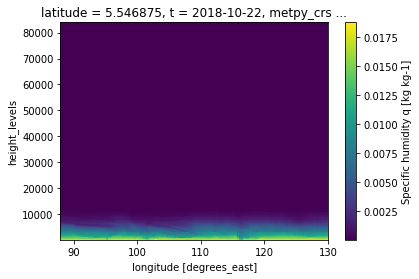

In [10]:
q.sel(latitude=5.5, method='nearest').plot()

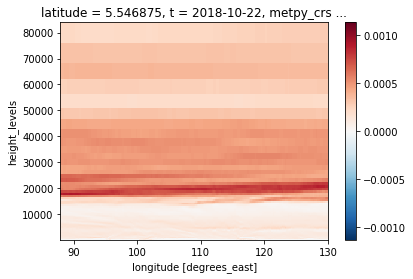

In [11]:
d_theta_dz.sel(latitude=5.5, method='nearest').plot()

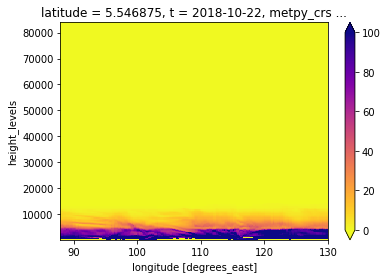

In [15]:
moist_stability.sel(latitude=5.5, method='nearest').plot(vmin=0, vmax=100, cmap='plasma_r')

In [11]:
sgt_run = 'diab'
plot_var = 'vg_sgt'

In [ ]:
# read in SGT tool data, and create variable for v_geo (geostrophic component of v-wind)
sgt_path = f"/nobackup/earshar/borneo/SGTool/N768/oct/{sgt_run}/filter_4_8/conv_g7x_v5"

sgt_file_v = f"{sgt_path}/OUT_v_20181021T1200Z_T0{Tp}.nc"
iris_array_v = iris.load(sgt_file_v)[0]
vtot_sgt = xr.DataArray.from_iris(iris_array_v).sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end))

sgt_file_vg = f"{sgt_path}/OUT_vg_20181021T1200Z_T0{Tp}.nc"
iris_array_vg = iris.load(sgt_file_vg)[0]
vgeo_sgt = xr.DataArray.from_iris(iris_array_vg).sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end))

sgt_file_vg_um = f"{sgt_path}/OUT_vg_um_20181021T1200Z_T0{Tp}.nc"
iris_array_vg_um = iris.load(sgt_file_vg_um)[0]
vgeo_sgt_nosmooth = xr.DataArray.from_iris(iris_array_vg_um).sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end))

sgt_file_w = f"{sgt_path}/OUT_w_20181021T1200Z_T0{Tp}.nc"
iris_array_w = iris.load(sgt_file_w)[0]
w_sgt = xr.DataArray.from_iris(iris_array_w).sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end))

: 

In [ ]:
# create new vertical height coordinate ('height_levels') and interpolate onto it
if Tp <= 12:
    coord_name = 'hybrid_ht'
else:
    coord_name = 'hybrid_ht_1'

ht_coords = uwind[coord_name].data.astype('int32')

if Tp <= 12:
    vwind = vwind.interp(hybrid_ht=ht_coords, method='linear')
    uwind = uwind.interp(hybrid_ht=ht_coords, method='linear')
    pv = pv.interp(hybrid_ht_1=ht_coords, method='linear')
else:
    vwind = vwind.interp(hybrid_ht_1=ht_coords, method='linear')
    uwind = uwind.interp(hybrid_ht_1=ht_coords, method='linear')
    pv = pv.interp(hybrid_ht=ht_coords, method='linear')

vwind = vwind.assign_coords(height_levels=(coord_name, ht_coords))
vwind = vwind.swap_dims({coord_name:"height_levels"})

uwind = uwind.assign_coords(height_levels=(coord_name, ht_coords))
uwind = uwind.swap_dims({coord_name:"height_levels"})

if Tp <= 12:
    pv = pv.assign_coords(height_levels=('hybrid_ht_1', ht_coords))
    pv = pv.swap_dims({"hybrid_ht_1":"height_levels"})
else:
    pv = pv.assign_coords(height_levels=('hybrid_ht', ht_coords))
    pv = pv.swap_dims({"hybrid_ht":"height_levels"})

# vwind = vwind.interp(hybrid_ht_1=ht_coords, method='linear')
# vwind = vwind.assign_coords(height_levels=("hybrid_ht_1", ht_coords))
# vwind = vwind.swap_dims({"hybrid_ht_1":"height_levels"})

: 

In [ ]:
# repeat for theta
theta = theta.interp(hybrid_ht=ht_coords, method='linear')
theta = theta.assign_coords(height_levels=("hybrid_ht", ht_coords))
theta = theta.swap_dims({"hybrid_ht":"height_levels"})

: 

In [ ]:
# repeat for the SGT tool data (L671 in plot_4p4.py)
vtot_sgt = vtot_sgt.assign_coords(height_levels=("model_level_number", 
                                    ht_coords)).swap_dims({"model_level_number":"height_levels"})

vgeo_sgt = vgeo_sgt.assign_coords(height_levels=("model_level_number", 
                                    ht_coords)).swap_dims({"model_level_number":"height_levels"})

vgeo_sgt_nosmooth = vgeo_sgt_nosmooth.assign_coords(height_levels=("model_level_number", 
                                                    ht_coords)).swap_dims({"model_level_number":"height_levels"})

w_sgt = w_sgt.assign_coords(height_levels=("model_level_number", 
                                    ht_coords)).swap_dims({"model_level_number":"height_levels"})

# convert w_sgt from m/s to cm/s
w_sgt = w_sgt * 100.

: 

In [ ]:
# # linearly interpolate the SGT tool data onto the N768 grid (L422; plot_4p4.py)
# vwind_sgt = vwind_sgt.interp(latitude=theta.latitude, longitude=theta.longitude)
# vg_wind = vg_wind.interp(latitude=theta.latitude, longitude=theta.longitude)
# vg_um_wind = vg_um_wind.interp(latitude=theta.latitude, longitude=theta.longitude)
# vwind = vwind.interp(latitude_1=theta.latitude, longitude=theta.longitude)

: 

In [ ]:
# linearly interpolate the SGT tool data onto the N768 grid, using 'theta' (TROUBLESHOOTING)
vtot_sgt = vtot_sgt.interp_like(theta)
vgeo_sgt = vgeo_sgt.interp_like(theta)
vgeo_sgt_nosmooth = vgeo_sgt_nosmooth.interp_like(theta)
vtot_n768 = vwind.interp_like(theta)

: 

In [ ]:
# extract PV and interpolate onto v-wind grid
pv = pv.interp_like(theta)
pv = pv * 1000000. 
if Tp <= 12:
    pv = pv.interp(longitude_1=vwind["longitude_1"],latitude=vwind["latitude_1"],method="linear")
else:
    pv = pv.interp(longitude=vwind["longitude"],latitude=vwind["latitude_1"],method="linear")

: 

In [ ]:
# read in Kevin Hodges' Borneo vortex track data from text file
df = pd.read_csv('/nobackup/earshar/borneo/bv_2018102112_track.csv',
                    na_filter=True,na_values="1.000000e+25")

# convert time integers to datetime objects
df['Time'] = pd.to_datetime(df['Time'], format='%Y%m%d%H')

# extract vortex track information between 12Z on 21st and 26th October
bv_lat = df.loc[0:20, "lat_vort"]; bv_lon = df.loc[0:20, "lon_vort"]
bv_time = df.loc[0:20, "Time"]

filter = bv_time==vwind.coords['t'].data
time_match = bv_time.where(filter).notna()
ind = int(time_match.loc[time_match==True].index.values)

: 

In [ ]:
# set up vertical cross-section 
lat_cs = 6.0 
lat_str = "%i" % lat_cs
lon_start = lon_start - 0.5
lon_end = lon_end + 0.5

: 

In [ ]:
# set up colour bar 
dl = 1.0; vmin = -15.0; vmax = -vmin + dl
Cmap,norm,Levels=normalise_cmap(vmin,vmax,0,dl,'bwr')
cb_label=r'Meridional wind $\mathregular{(m\,s^{-1})}$'

: 

In [ ]:
# select the cross-section location 

# N768 total wind
arr_vt = vtot_n768.sel(latitude_1=lat_cs, method="nearest")
if Tp <= 12:
    arr_vt = arr_vt.sel(longitude_1=slice(lon_start,lon_end),
                        height_levels=slice(50, 15000) )
else:
    arr_vt = arr_vt.sel(longitude=slice(lon_start,lon_end),
                        height_levels=slice(50, 15000) )  

# SGT total wind
arr_vt_sgt = vtot_sgt.sel(latitude=lat_cs, method="nearest")
arr_vt_sgt = arr_vt_sgt.sel(longitude=slice(lon_start,lon_end),
                            height_levels=slice(50, 15000) )

# SGT geostrophic wind (smoothed/filtered)
arr_vg_sgt = vgeo_sgt.sel(latitude=lat_cs, method="nearest")
arr_vg_sgt = arr_vg_sgt.sel(longitude=slice(lon_start,lon_end),
                            height_levels=slice(50, 15000) )

# SGT geostrophic wind (unfiltered)
arr_vg_sgt_ns = vgeo_sgt_nosmooth.sel(latitude=lat_cs, method="nearest")
arr_vg_sgt_ns = arr_vg_sgt_ns.sel(longitude=slice(lon_start,lon_end),
                            height_levels=slice(50, 15000) )

# SGT vertical velocity 
arr_w = w_sgt.sel(latitude=lat_cs, method="nearest")
arr_w = arr_w.sel(longitude=slice(lon_start,lon_end),
                height_levels=slice(50, 15000) )

# N768 theta 
arr_th = theta.sel(latitude=lat_cs, method="nearest")
arr_th = arr_th.sel(longitude=slice(lon_start,lon_end),
                    height_levels=slice(50, 15000) )

# N768 potential vorticity 
arr_pv = pv.sel(latitude_1=lat_cs, method="nearest")
arr_pv = arr_pv.sel(longitude=slice(lon_start,lon_end),
                    height_levels=slice(50, 15000) )

: 

In [ ]:
# interpolate to new height coordinates before plotting 
ht_coords = np.arange(0, 13500, 250)
arr_vt = arr_vt.interp(height_levels=ht_coords,method="linear")
arr_vt_sgt = arr_vt_sgt.interp(height_levels=ht_coords,method="linear")
arr_vg_sgt = arr_vg_sgt.interp(height_levels=ht_coords,method="linear")
arr_vg_sgt_ns = arr_vg_sgt_ns.interp(height_levels=ht_coords,method="linear")
arr_th = arr_th.interp(height_levels=ht_coords,method="linear")
arr_pv = arr_pv.interp(height_levels=ht_coords,method="linear")
arr_w = arr_w.interp(height_levels=ht_coords,method="linear")

: 

In [ ]:
# set up longitude coordinate before plotting
lon_dim = np.arange(np.rint(arr_th.longitude[0].data),
                    np.rint(arr_th.longitude[-1].data)+0.25, 0.25)

arr_vt_sgt = arr_vt_sgt.interp(longitude=lon_dim, method="linear")
arr_vg_sgt = arr_vg_sgt.interp(longitude=lon_dim, method="linear")
arr_vg_sgt_ns = arr_vg_sgt_ns.interp(longitude=lon_dim, method="linear")
arr_th = arr_th.interp(longitude=lon_dim, method="linear")
arr_w = arr_w.interp(longitude=lon_dim, method="linear")

if Tp <= 12:
    arr_vt = arr_vt.interp(longitude_1=lon_dim, method="linear")
    arr_pv = arr_pv.interp(longitude_1=lon_dim, method="linear")
else:
    arr_vt = arr_vt.interp(longitude=lon_dim, method="linear")
    arr_pv = arr_pv.interp(longitude=lon_dim, method="linear")

: 

In [ ]:
# select variable to plot 
if plot_var == 'v_sgt':
    variable_string = 'vtot_sgt'
    vcomp = arr_vt_sgt
elif plot_var == 'v_n768':
    variable_string = 'vtot_n768'
    vcomp = arr_vt
elif plot_var == 'vg_sgt':
    variable_string = 'vgeo_sgt'
    vcomp = arr_vg_sgt
elif plot_var == 'vg_sgt_ns':
    variable_string = 'vgeo_sgt_nosmooth'
    vcomp = arr_vg_sgt_ns

: 

In [ ]:
# tickmarks and labels (L1553 in plot_4p4.py)
fig = plt.figure(figsize=[9,6])
ax = plt.axes()
ax.grid(True)

xint = 1; yint = 4
if Tp <= 12:
    ts = np.rint(arr_vt.longitude_1[0].data)
    tf = np.rint(arr_vt.longitude_1[-1].data)
    dim_size = len(arr_vt.longitude_1)
else:
    ts = np.rint(arr_vt.longitude[0].data)
    tf = np.rint(arr_vt.longitude[-1].data)
    dim_size = len(arr_vt.longitude)
ax.set_xlabel(r'longitude ($\degree$E)', fontsize='large')

# set x-axis tickmarks every 4º
ax.set_xlim(0, dim_size-1)
ax.set_xticks(np.arange(0, dim_size+1, 16) )
ax.set_xticklabels(np.arange(int(ts), int(tf+1), yint) , fontsize='large')

# y-axis tickmarks and labels (every 1 km)
mlev_size = len(arr_vt.height_levels)
ax.set_yticks(np.arange(0, mlev_size, 4) )
ax.set_yticklabels(arr_vt.height_levels[::4].data)
ax.set_ylabel('Height (m)', fontsize='large')

# plot cross-section (total wind)
var_contour = plt.contourf(vcomp, levels=Levels, extend='max', cmap=Cmap)

# overlay line contours (vertical velocity)
# w_contour = plt.contour(arr_w, levels=np.arange(-2, 10, 4), colors=['deepskyblue'])

# plot colourbar 
var_cbar = fig.colorbar(var_contour)
var_cbar.set_label(cb_label, fontsize='large')
plt.savefig(f'{variable_string}_cross_section_t{Tp}_{lat_str}N_{sgt_run}.png',dpi=200)

: 

In [ ]:
# # tickmarks and labels (L1553 in plot_4p4.py)
# fig = plt.figure(figsize=[9,6])
# ax = plt.axes()
# ax.grid(True)

# xint = 1; yint = 4
# ts = np.rint(arr_vt.longitude[0].data)
# tf = np.rint(arr_vt.longitude[-1].data)
# dim_size = len(arr_vt.longitude)
# ax.set_xlabel(r'longitude ($\degree$E)', fontsize='large')

# # set x-axis tickmarks every 2º
# ax.set_xlim(0, dim_size-1)
# ax.set_xticks(np.arange(0, dim_size+1, 16) )
# ax.set_xticklabels(np.arange(int(ts), int(tf+1), yint) , fontsize='large')

# # y-axis tickmarks and labels 
# mlev_size = len(arr_vt.height_levels)
# ax.set_yticks(np.arange(0, mlev_size, 4) )
# ax.set_yticklabels(arr_vt.height_levels[::4].data)
# ax.set_ylabel('Height (m)', fontsize='large')

# # plot cross-section (total wind)
# var_contour = plt.contourf(arr_vt, levels=Levels, extend='max', cmap=Cmap)
# var_cbar = fig.colorbar(var_contour)
# var_cbar.set_label(cb_label, fontsize='large')
# plt.savefig(f'vtot_n768_cross_section_t{Tp}_{lat_str}N.png',dpi=200)

: 

In [ ]:
# # tickmarks and labels (L1553 in plot_4p4.py)
# fig = plt.figure(figsize=[9,6])
# ax = plt.axes()
# ax.grid(True)

# xint = 1; yint = 4
# ts = np.rint(arr_vt.longitude[0].data)
# tf = np.rint(arr_vt.longitude[-1].data)
# dim_size = len(arr_vt.longitude)
# ax.set_xlabel(r'longitude ($\degree$E)', fontsize='large')

# # set x-axis tickmarks every 2º
# ax.set_xlim(0, dim_size-1)
# ax.set_xticks(np.arange(0, dim_size+1, 16) )
# ax.set_xticklabels(np.arange(int(ts), int(tf+1), yint) , fontsize='large')

# # y-axis tickmarks and labels 
# mlev_size = len(arr_vt.height_levels)
# ax.set_yticks(np.arange(0, mlev_size, 4) )
# ax.set_yticklabels(arr_vt.height_levels[::4].data)
# ax.set_ylabel('Height (m)', fontsize='large')

# # plot cross-section (geostrophic wind)
# var_contour = plt.contourf(arr_vg, levels=Levels, extend='max', cmap=Cmap)
# var_cbar = fig.colorbar(var_contour)
# var_cbar.set_label(cb_label, fontsize='large')
# plt.savefig(f'vgeo_sgt_smooth_cross_section_t{Tp}_{lat_str}N.png',dpi=200)

: 

In [ ]:
# # tickmarks and labels (L1553 in plot_4p4.py)
# fig = plt.figure(figsize=[9,6])
# ax = plt.axes()
# ax.grid(True)

# xint = 1; yint = 4
# ts = np.rint(arr_vt.longitude[0].data)
# tf = np.rint(arr_vt.longitude[-1].data)
# dim_size = len(arr_vt.longitude)
# ax.set_xlabel(r'longitude ($\degree$E)', fontsize='large')

# # set x-axis tickmarks every 2º
# ax.set_xlim(0, dim_size-1)
# ax.set_xticks(np.arange(0, dim_size+1, 16) )
# ax.set_xticklabels(np.arange(int(ts), int(tf+1), yint) , fontsize='large')

# # y-axis tickmarks and labels 
# mlev_size = len(arr_vt.height_levels)
# ax.set_yticks(np.arange(0, mlev_size, 4) )
# ax.set_yticklabels(arr_vt.height_levels[::4].data)
# ax.set_ylabel('Height (m)', fontsize='large')

# # plot cross-section (geostrophic wind)
# var_contour = plt.contourf(arr_vg2, levels=Levels, extend='max', cmap=Cmap)
# var_cbar = fig.colorbar(var_contour)
# var_cbar.set_label(cb_label, fontsize='large')
# plt.savefig(f'vgeo_sgt_non_smooth_cross_section_t{Tp}_{lat_str}N.png',dpi=200)

: 